In [1]:
# importing libraries
import boto3
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import recall_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn import metrics


# defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'webster-data445-bucket'
bucket = s3.Bucket(bucket_name)

# defining the csv file
file_key = 'train.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# reading csv file
bikes = pd.read_csv(file_content_stream)
bikes.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
# defining the csv file
file_key = 'test.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# reading csv file
bikes_test = pd.read_csv(file_content_stream)
bikes_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [3]:
temp = pd.DataFrame()

temp['month'] = bikes.datetime.apply(lambda x : x.split()[0].split('-')[1]).astype('int')
temp['hour'] = bikes.datetime.apply(lambda x : x.split()[1].split(':')[0]).astype('int')

bikes = pd.concat([temp , bikes] , axis = 1)
bikes.drop(labels = ['datetime', 'casual', 'registered'], axis = 1 , inplace = True)

bikes.head()

,month,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,1,0,1,0,0,1,9.84,14.395,81,0.0,16
1,1,1,1,0,0,1,9.02,13.635,80,0.0,40
2,1,2,1,0,0,1,9.02,13.635,80,0.0,32
3,1,3,1,0,0,1,9.84,14.395,75,0.0,13
4,1,4,1,0,0,1,9.84,14.395,75,0.0,1


In [4]:
# defining X and Y
X = bikes.iloc[:,:-1].values
Y = bikes.iloc[:,-1]

# splitting into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

# scaling the data
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [5]:
# simple linear regression using hour (highest correlation with count)
lr = LinearRegression()

lm_md = lr.fit(np.reshape(X_train[:,1], (-1, 1)), Y_train)

# predicting on test
lm_md_pred = lr.predict(np.reshape(X_test[:,1], (-1, 1)))

In [6]:
# calculating mse
lm_md_mse = np.mean(np.power(lm_md_pred - Y_test, 2))

lm_md_r2 = metrics.r2_score(Y_test, lm_md_pred)

In [7]:
# multiple linear regression using all variables
lm_md2 = lr.fit(X_train, Y_train)

# predicting on test
lm_md2_pred = lm_md2.predict(X_test)

In [8]:
lm_md2_mse = np.mean(np.power(lm_md2_pred - Y_test, 2))

lm_md2_r2 = metrics.r2_score(Y_test, lm_md2_pred)

In [9]:
# k nearest neighbors
r_squared = []
max_rsquared = 0
best_k = 0

for k in range(1, 21):
    
    knn = KNeighborsRegressor(n_neighbors = k)    
    knn.fit(X_train, Y_train)
    
    knn_pred = knn.predict(X_test)
    
    accuracy = metrics.r2_score(Y_test , knn_pred)
    r_squared.append(accuracy)
    
    if accuracy > max_rsquared:
        
        max_rsquared = accuracy
        best_k = k
        
print('Best k is:', best_k)

# 1 neighbor is the best for our data

Best k is: 5


In [10]:
# k nearest neighbors regression with number of neigbors = 1
knn = KNeighborsRegressor(n_neighbors = 5).fit(X_train, Y_train)

knn_pred = knn.predict(X_test)

In [11]:
knn_mse = np.mean(np.power(knn_pred - Y_test, 2))

knn_r2 = metrics.r2_score(Y_test, knn_pred)

In [12]:
# support vector machine with rbf kernel 
svr_md = SVR(kernel = 'rbf').fit(X_train, Y_train)

svr_pred = svr_md.predict(X_test)

In [13]:
svr_mse = np.mean(np.power(svr_pred - Y_test, 2))

svr_r2 = metrics.r2_score(Y_test, svr_pred)

In [14]:
# random forest
rf_md = RandomForestRegressor(random_state = 1).fit(X_train, Y_train)

rf_pred = rf_md.predict(X_test)

In [15]:
rf_mse = np.mean(np.power(rf_pred - Y_test, 2))

rf_r2 = metrics.r2_score(Y_test, rf_pred)

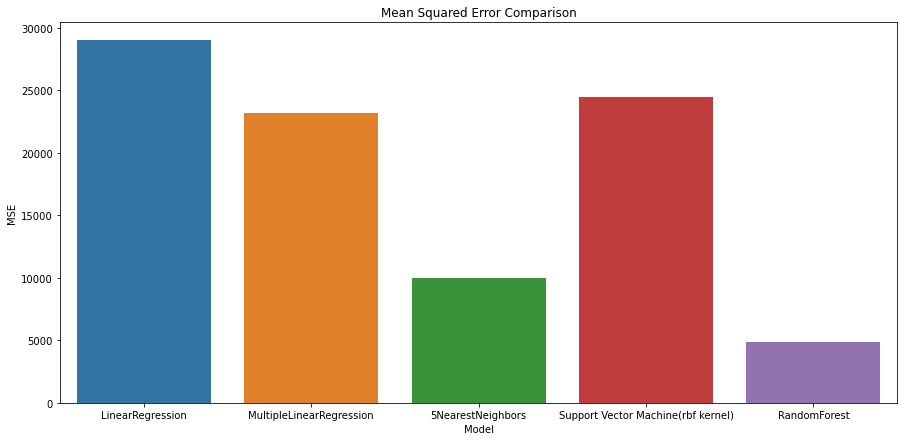

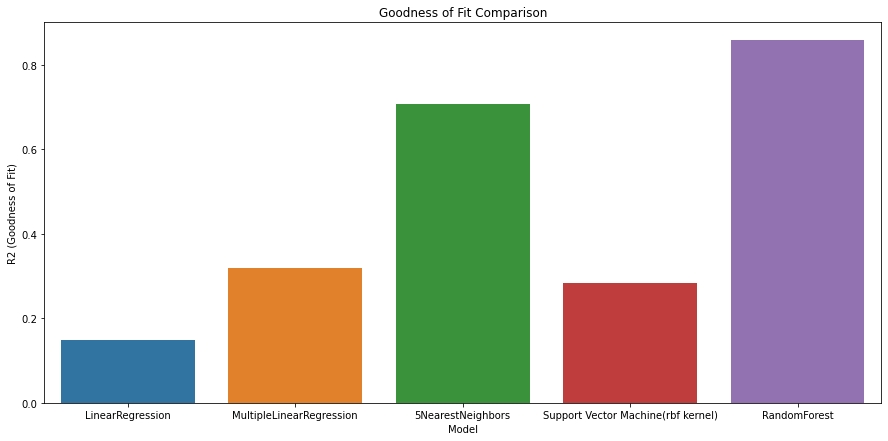

In [16]:
# model comparisons
md_names = ['LinearRegression', 'MultipleLinearRegression', '5NearestNeighbors', 'Support Vector Machine(rbf kernel)',  'RandomForest']

model_mse = [lm_md_mse, lm_md2_mse, knn_mse, svr_mse, rf_mse]

model_r2 =  [lm_md_r2, lm_md2_r2, knn_r2, svr_r2, rf_r2]

plt.figure(figsize = (15, 7))
sns.barplot(x = md_names, y = model_mse)
plt.title('Mean Squared Error Comparison')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.show()

plt.figure(figsize = (15, 7))
sns.barplot(x = md_names, y = model_r2)
plt.title('Goodness of Fit Comparison')
plt.xlabel('Model')
plt.ylabel('R2 (Goodness of Fit)')
plt.show()

# Based on this, we would choose the random forest model because it has the highest R2 and the lowest MSE.

In [17]:
model_mse

[28993.362051340242,
 23182.707051160673,
 9963.053333333331,
 24453.507309333836,
 4831.161793489755]

In [18]:
model_r2

[0.1497581130900748,
 0.3201578846925166,
 0.7078294938504388,
 0.2828911611065619,
 0.8583242567043377]

In [19]:
temp2 = pd.DataFrame()
temp2['month'] = bikes_test.datetime.apply(lambda x : x.split()[0].split('-')[1]).astype('int')
temp2['hour'] = bikes_test.datetime.apply(lambda x : x.split()[1].split(':')[0]).astype('int')
bikes_test = pd.concat([temp2 , bikes_test], axis = 1)

final_data = bikes_test.drop(labels = 'datetime', axis = 1 , inplace = False)

In [20]:
final_data = scaler.fit_transform(final_data)

final_pred = rf_md.predict(final_data)

bikes_test['count'] = final_pred

bikes_test = bikes_test[['datetime', 'count']]
bikes_test.describe()

,count
count,6493.000000
mean,192.686110
std,165.236895
min,1.410000
25%,54.010000
50%,157.070000
75%,282.880000
max,861.810000


In [29]:
temp3 = pd.DataFrame()

#temp3['month'] = bikes_test.datetime.apply(lambda x : x.split()[0].split('-')[1]).astype('int')
temp3['hour'] = bikes_test.datetime.apply(lambda x : x.split()[1].split(':')[0]).astype('int')

bikes_results = pd.concat([temp3 , bikes_test] , axis = 1)

result_sums_hour = bikes_results.groupby(bikes_results['hour']).sum().sort_values(['count'], ascending = False)
result_sums_hour

,count
hour,
17,120563.122500
18,115843.007429
8,97281.900000
19,87226.398667
16,84556.497714
13,70582.752333
15,70535.779000
14,69504.359000
12,68414.260000


In [28]:
temp4 = pd.DataFrame()

temp4['month'] = bikes_test.datetime.apply(lambda x : x.split()[0].split('-')[1]).astype('int')
#temp3['hour'] = bikes_test.datetime.apply(lambda x : x.split()[1].split(':')[0]).astype('int')

bikes_results = pd.concat([temp4 , bikes_test] , axis = 1)

result_sums_month = (bikes_results.groupby(bikes_results['month']).sum() / 2).sort_values(['count'], ascending = False)
result_sums_month

,count
month,
8,70057.629417
5,68834.894750
7,68217.171060
6,64961.470214
9,59803.425667
10,58824.234845
4,50537.481571
11,49229.416405
3,43239.022833


In [ ]:
bikes_test.describe()